<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/ch-5-sol/solutions/5_Modeling_Objectives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a contrastive CNN on MNIST.

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [64]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(3407)

In [155]:
# custom dataset to load pairs of examples
class MnistPairs(Dataset):
    def __init__(self, train=True):
        self.torch_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=train,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)
    
    def __len__(self):
        return len(self.torch_dataset)
    
    def __getitem__(self, idx):
        x1, y1 = self.torch_dataset[idx]
        # method to give matching pairs about half the time
        # potential TODO: speed this up with pre-processing
        same_class = random.randint(0, 1)
        if same_class:
            while True:
                x2, y2 = random.choice(self.torch_dataset)
                if y2 == y1:
                    break
        else:
            while True:
                x2, y2 = random.choice(self.torch_dataset)
                if y2 != y1:
                    break
        label = torch.tensor([y1 != y2], dtype=torch.float32)
        return (x1, y1, x2, y2, label)

In [147]:
# define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.linear_layers = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
        )
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.reshape(-1, 1024)
        x = self.linear_layers(x)
        return x

In [167]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

### Training

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [137]:
pair_dataset = MnistPairs(train=True)
pair_loader = DataLoader(pair_dataset, batch_size=128, shuffle=False)

In [138]:
model = CNN().to(device).train()
criterion = ContrastiveLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [139]:
max_epochs = 10
losses = []
for epoch in range(max_epochs):
    pbar = tqdm(enumerate(pair_loader), total=len(pair_loader))
    for it, (x1, y1, x2, y2, label) in pbar:
        x1 = x1.to(device)
        out1 = model(x1)
    
        x2 = x2.to(device)
        out2 = model(x2)
    
        optimizer.zero_grad()
        label = label.to(device)
        loss = criterion(out1, out2, label)
    
        loss.backward()
        optimizer.step()
    
        losses.append(loss.item())
        pbar.set_description(f"epoch: {epoch}, loss: {loss.item():.5f}")

epoch: 9, loss: 0.31004: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s]


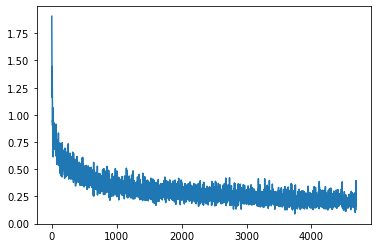

In [140]:
plt.plot(losses);
plt.show()

# Measure the classification accuracy of your model by using a few held-out examples from each class to compare each test example to.

In [141]:
test_dataset = MnistPairs(train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [142]:
diffs = []
sames = []
for it, (x1, y1, x2, y2, label) in enumerate(test_loader):
    x1 = x1.to(device)
    out1 = model(x1)

    x2 = x2.to(device)
    out2 = model(x2)

    dist = torch.linalg.norm(out1 - out2, ord=2)

    if y1 == y2:
        sames.append((y1, y2, dist))
    else:
        diffs.append((y1, y2, dist))

    if it == 50:
        break

In [145]:
# dist should be large
print("DIFFERENT")
for (y1, y2, dist) in diffs[:5]:
    print(f"y1: {y1}, y2: {y2}, dist: {dist}")

DIFFERENT
y1: tensor([7]), y2: tensor([8]), dist: 2.486117362976074
y1: tensor([2]), y2: tensor([1]), dist: 2.0656850337982178
y1: tensor([1]), y2: tensor([8]), dist: 2.863703727722168
y1: tensor([1]), y2: tensor([0]), dist: 4.2741899490356445
y1: tensor([0]), y2: tensor([2]), dist: 2.798466682434082


In [146]:
# dist should be small
print("SAME")
for (y1, y2, dist) in sames[:5]:
    print(f"y1: {y1}, y2: {y2}, dist: {dist}")

SAME
y1: tensor([0]), y2: tensor([0]), dist: 0.03381603583693504
y1: tensor([4]), y2: tensor([4]), dist: 0.5029099583625793
y1: tensor([4]), y2: tensor([4]), dist: 0.3329090476036072
y1: tensor([9]), y2: tensor([9]), dist: 0.26713234186172485
y1: tensor([5]), y2: tensor([5]), dist: 1.240917444229126
